In [ ]:
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques/
# 这里大部分代码参考了《动手学深度学习》课程，https://zh-v2.d2l.ai/chapter_multilayer-perceptrons/kaggle-house-price.html#id3，旨在与不使用K-fold的代码进行对比。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

In [3]:
# 读取数据
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
all_feature = pd.concat([train.iloc[:, 1:-1], test.iloc[:, 1:]])

In [5]:
# 清洗数据

# 用z-score标准化数据，跳过object类
for col in all_feature.columns:
    if all_feature[col].dtype != 'object':
        all_feature[col] = (all_feature[col] - all_feature[col].mean()) / all_feature[col].std()
        all_feature[col] = all_feature[col].fillna(0)

# 将所有object类的数据使用1-hot编码转化成数值
all_feature = pd.get_dummies(all_feature, dummy_na=True, dtype=float)
print(all_feature.shape)

(2919, 330)


In [6]:
n_train = train.shape[0]
train_features = torch.tensor(all_feature[:n_train].values)
test_features = torch.tensor(all_feature[n_train:].values)
train_labels = torch.tensor(train['SalePrice'].values.reshape(-1, 1))

In [7]:
class HousePricesDataset(Dataset):
    def __init__(self, features, label=None):
        super(HousePricesDataset, self).__init__()
        self.features = features
        self.label = label
    
    def __getitem__(self, index):
        if self.label != None:
            return self.features[index], self.label[index]
        else:
            return self.features[index]
    
    def __len__(self):
        return len(self.features)


In [8]:
# 划分数据集
train_dataset = HousePricesDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataset = HousePricesDataset(test_features)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [9]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(nn.Linear(input_size, 256),
                                   nn.ReLU(),
                                   nn.Linear(256, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, 64),
                                   nn.ReLU(),
                                   nn.Linear(64, output_size))
        
    def forward(self, x):
        return self.model(x)

In [10]:
# 初始化参数
input_size = train_features.shape[1]
output_size = 1
batch_size = 16
learning_rate = 0.001
epochs = 1000

# 划分数据集
train_dataset = HousePricesDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = HousePricesDataset(test_features)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
loss = nn.MSELoss()

def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    features = features.float()
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [ ]:
# 定义训练函数
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    # 损失函数的值
    train_ls, test_ls = [], []

    # 划分数据集
    train_dataset = HousePricesDataset(train_features, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = HousePricesDataset(test_features, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_loader:
            X = X.float()
            y = y.float()
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
            
    return train_ls, test_ls

In [36]:
# K-交叉训练
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = MLP(input_size, output_size)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plt.plot(list(range(1, num_epochs + 1)), train_ls)
            plt.plot(list(range(1, num_epochs + 1)), valid_ls)
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.149412, 验证log rmse0.144200
折2，训练log rmse0.149592, 验证log rmse0.169603
折3，训练log rmse0.146223, 验证log rmse0.156460
折4，训练log rmse0.149570, 验证log rmse0.143872
折5，训练log rmse0.143893, 验证log rmse0.173991
5-折验证: 平均训练log rmse: 0.147738, 平均验证log rmse: 0.157625


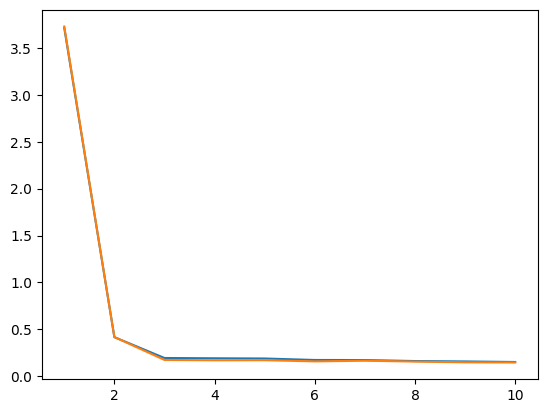

In [45]:
k, num_epochs, lr, weight_decay, batch_size = 5, 10, learning_rate, 1e-3, 16
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = MLP(input_size, output_size)
    train_ls, _ = train(net, train_features, train_labels, test_features, None, num_epochs, lr, weight_decay, batch_size)
    plt.plot(np.arange(1, num_epochs + 1), train_ls)
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features.float()).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    return submission

训练log rmse：0.113873


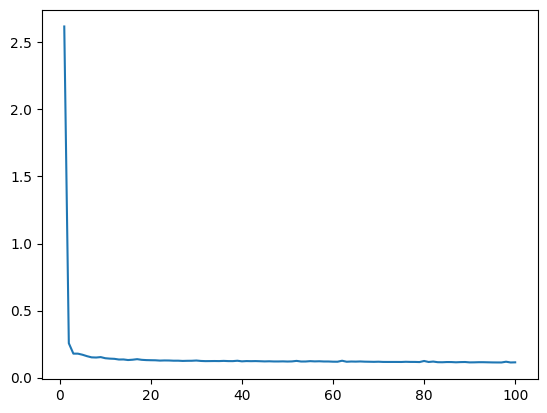

In [51]:
sub = train_and_pred(train_features, test_features, train_labels, test_data=test, num_epochs=100, lr=learning_rate, weight_decay=1e-3, batch_size=16)

In [53]:
sub.to_csv('submission.csv', index=False)

In [ ]:
# 由于数据集较小，我们使用K-fold降低过拟合风险，而没有划分成训练集和测试集，得到的结果在kaggle上分数为0.14，比之前的0.19更优